In [1]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from semantics.pipeline import Pipeline
from semantics.train import Trainer, TrainerConfig
import semantics.vision as sv

# Build pipeline
batch_size = 128
dim = 64
img_size = 32
patch_size = 2
window_size = 4
num_heads = 4
modulation = True
num_channels = 3
channel_mean = 0.0
channel_std = 0.1
channel_snr = None
channel_avg_power = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = sv.encoder.WITTEncoder(
    img_size = img_size, 
    patch_size = patch_size, 
    embed_dims = [32, 64, 128, 256],
    depths = [2, 2, 2, 2],
    num_heads = [4, 8, 8, 8], 
    C_out = 32, 
    window_size = 4, 
    use_modulation = modulation,
    in_chans = num_channels
).to(device)

decoder = sv.decoder.WITTDecoder(
    img_size = img_size, 
    patch_size = patch_size, 
    embed_dims = [256, 128, 64, 32],
    depths = [2, 2, 2, 2], 
    num_heads = [8, 8, 8, 4], 
    C_in = 32, 
    window_size = 4, 
    use_modulation = modulation,
    out_chans = num_channels
).to(device)

channel = sv.channels.AWGNChannel(
    mean = channel_mean,
    std = channel_std,
    snr = channel_snr,
    avg_power = channel_avg_power
).to(device)

pipeline = Pipeline(encoder, channel, decoder).to(device)

# Data
transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor()])
train_ds = datasets.CIFAR10("./data", train=True,  download=True, transform=transform)
val_ds   = datasets.CIFAR10("./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Optimizer and Loss
optimizer = Adam(pipeline.parameters(), lr=3e-4)
criterion = torch.nn.L1Loss()

# Simple metrics
metrics = {
        "psnr": sv.metrics.PSNRMetric(),
        'ssim': sv.metrics.SSIMMetric(data_range=1.0, size_average=True, channel=3)
    }

# Train
cfg = TrainerConfig(
    num_epochs=50,
    learning_rate=3e-4,
    use_amp=True,          # turn on mixed precision
    amp_dtype="auto",      # auto-select bf16/fp16
    grad_accum_steps=1,    # increase if batches are small
    clip_grad_norm=1.0,    # optional safety
    compile_model=False,   # set True if PyTorch 2.x and stable graph
)
trainer = Trainer(
    pipeline=pipeline,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=criterion,
    config=cfg,
    metrics=metrics,
)
trainer.train()

/home/jmadden2/anaconda3/envs/semantics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[epoch 000] epoch=0.0000 train_loss=0.1634 val_loss=0.1287 val_psnr=15.3452 val_ssim=0.1725


[epoch 001] epoch=1.0000 train_loss=0.1108 val_loss=0.0957 val_psnr=17.6315 val_ssim=0.3478


[epoch 002] epoch=2.0000 train_loss=0.0885 val_loss=0.0823 val_psnr=18.7788 val_ssim=0.4477


[epoch 003] epoch=3.0000 train_loss=0.0789 val_loss=0.0752 val_psnr=19.5340 val_ssim=0.5012


[epoch 004] epoch=4.0000 train_loss=0.0736 val_loss=0.0711 val_psnr=19.9875 val_ssim=0.5414


[epoch 005] epoch=5.0000 train_loss=0.0700 val_loss=0.0712 val_psnr=20.0768 val_ssim=0.5791


[epoch 006] epoch=6.0000 train_loss=0.0674 val_loss=0.0662 val_psnr=20.5457 val_ssim=0.5924


[epoch 007] epoch=7.0000 train_loss=0.0653 val_loss=0.0645 val_psnr=20.7951 val_ssim=0.6060


[epoch 008] epoch=8.0000 train_loss=0.0637 val_loss=0.0631 val_psnr=20.9551 val_ssim=0.6227


[epoch 009] epoch=9.0000 train_loss=0.0622 val_loss=0.0631 val_psnr=21.0019 val_ssim=0.6361


[epoch 010] epoch=10.0000 train_loss=0.0611 val_loss=0.0607 val_psnr=21.2968 val_ssim=0.6392


[epoch 011] epoch=11.0000 train_loss=0.0602 val_loss=0.0598 val_psnr=21.3899 val_ssim=0.6489


[epoch 012] epoch=12.0000 train_loss=0.0593 val_loss=0.0593 val_psnr=21.5129 val_ssim=0.6528


[epoch 013] epoch=13.0000 train_loss=0.0586 val_loss=0.0598 val_psnr=21.4665 val_ssim=0.6665


[epoch 014] epoch=14.0000 train_loss=0.0581 val_loss=0.0580 val_psnr=21.6431 val_ssim=0.6664


[epoch 015] epoch=15.0000 train_loss=0.0576 val_loss=0.0574 val_psnr=21.7495 val_ssim=0.6649


[epoch 016] epoch=16.0000 train_loss=0.0571 val_loss=0.0570 val_psnr=21.8138 val_ssim=0.6686


[epoch 017] epoch=17.0000 train_loss=0.0567 val_loss=0.0565 val_psnr=21.8632 val_ssim=0.6714


[epoch 018] epoch=18.0000 train_loss=0.0565 val_loss=0.0562 val_psnr=21.9234 val_ssim=0.6749


[epoch 019] epoch=19.0000 train_loss=0.0562 val_loss=0.0565 val_psnr=21.8783 val_ssim=0.6812


[epoch 020] epoch=20.0000 train_loss=0.0558 val_loss=0.0560 val_psnr=21.9683 val_ssim=0.6778


[epoch 021] epoch=21.0000 train_loss=0.0556 val_loss=0.0559 val_psnr=21.9655 val_ssim=0.6864


[epoch 022] epoch=22.0000 train_loss=0.0552 val_loss=0.0553 val_psnr=22.0279 val_ssim=0.6869


[epoch 023] epoch=23.0000 train_loss=0.0551 val_loss=0.0559 val_psnr=21.9479 val_ssim=0.6904


[epoch 024] epoch=24.0000 train_loss=0.0547 val_loss=0.0550 val_psnr=22.0825 val_ssim=0.6929


[epoch 025] epoch=25.0000 train_loss=0.0546 val_loss=0.0546 val_psnr=22.1188 val_ssim=0.6950


[epoch 026] epoch=26.0000 train_loss=0.0543 val_loss=0.0557 val_psnr=22.0253 val_ssim=0.6950


[epoch 027] epoch=27.0000 train_loss=0.0541 val_loss=0.0553 val_psnr=22.0937 val_ssim=0.6977


[epoch 028] epoch=28.0000 train_loss=0.0540 val_loss=0.0542 val_psnr=22.1984 val_ssim=0.6953


[epoch 029] epoch=29.0000 train_loss=0.0537 val_loss=0.0545 val_psnr=22.2046 val_ssim=0.7028


[epoch 030] epoch=30.0000 train_loss=0.0536 val_loss=0.0546 val_psnr=22.1952 val_ssim=0.6970


[epoch 031] epoch=31.0000 train_loss=0.0535 val_loss=0.0536 val_psnr=22.2635 val_ssim=0.7018


[epoch 032] epoch=32.0000 train_loss=0.0533 val_loss=0.0536 val_psnr=22.3063 val_ssim=0.7002


[epoch 033] epoch=33.0000 train_loss=0.0532 val_loss=0.0535 val_psnr=22.3189 val_ssim=0.7003


[epoch 034] epoch=34.0000 train_loss=0.0530 val_loss=0.0532 val_psnr=22.3356 val_ssim=0.7039


[epoch 035] epoch=35.0000 train_loss=0.0529 val_loss=0.0531 val_psnr=22.3546 val_ssim=0.7015


[epoch 036] epoch=36.0000 train_loss=0.0527 val_loss=0.0530 val_psnr=22.3490 val_ssim=0.7081


[epoch 037] epoch=37.0000 train_loss=0.0527 val_loss=0.0529 val_psnr=22.3754 val_ssim=0.7063


[epoch 038] epoch=38.0000 train_loss=0.0525 val_loss=0.0534 val_psnr=22.3661 val_ssim=0.7070


[epoch 039] epoch=39.0000 train_loss=0.0525 val_loss=0.0527 val_psnr=22.3960 val_ssim=0.7092


[epoch 040] epoch=40.0000 train_loss=0.0523 val_loss=0.0528 val_psnr=22.4057 val_ssim=0.7073


[epoch 041] epoch=41.0000 train_loss=0.0522 val_loss=0.0526 val_psnr=22.4378 val_ssim=0.7101


[epoch 042] epoch=42.0000 train_loss=0.0521 val_loss=0.0523 val_psnr=22.4741 val_ssim=0.7076


[epoch 043] epoch=43.0000 train_loss=0.0521 val_loss=0.0527 val_psnr=22.4559 val_ssim=0.7133


[epoch 044] epoch=44.0000 train_loss=0.0519 val_loss=0.0526 val_psnr=22.4264 val_ssim=0.7129


[epoch 045] epoch=45.0000 train_loss=0.0519 val_loss=0.0525 val_psnr=22.4945 val_ssim=0.7117


[epoch 046] epoch=46.0000 train_loss=0.0517 val_loss=0.0527 val_psnr=22.4203 val_ssim=0.7165


[epoch 047] epoch=47.0000 train_loss=0.0517 val_loss=0.0524 val_psnr=22.4786 val_ssim=0.7156


[epoch 048] epoch=48.0000 train_loss=0.0516 val_loss=0.0519 val_psnr=22.5165 val_ssim=0.7164


[epoch 049] epoch=49.0000 train_loss=0.0515 val_loss=0.0521 val_psnr=22.4993 val_ssim=0.7160


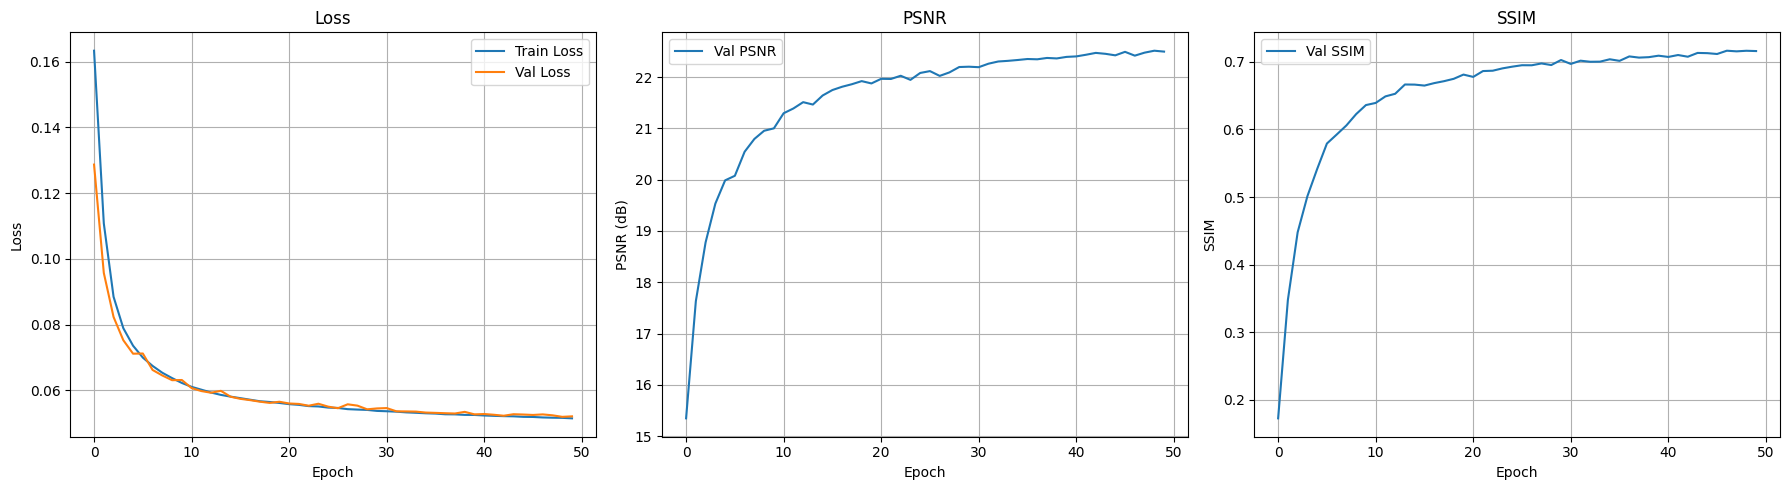

In [6]:
history = trainer.history

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train & Val Loss
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# PSNR
axes[1].plot(history["val_psnr"], label="Val PSNR")
axes[1].set_title("PSNR")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("PSNR (dB)")
axes[1].legend()
axes[1].grid()

# SSIM
axes[2].plot(history["val_ssim"], label="Val SSIM")
axes[2].set_title("SSIM")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("SSIM")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

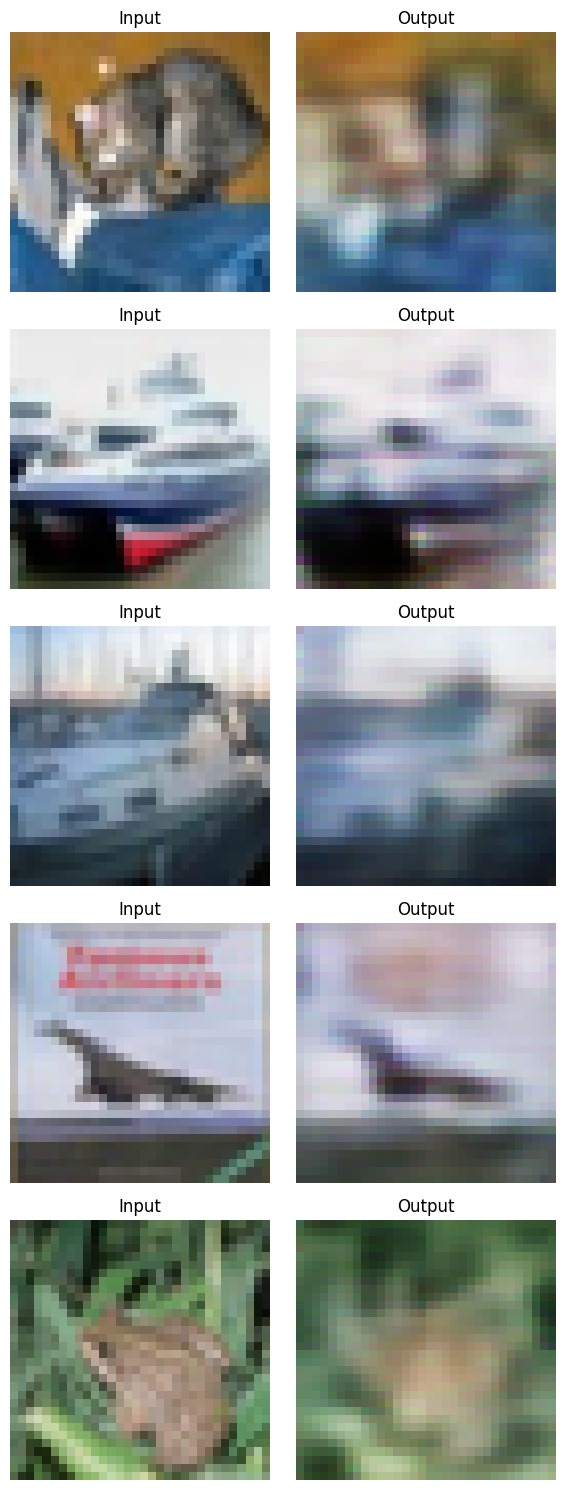

In [5]:
import numpy as np

# Get a batch of images from the validation loader
images, _ = next(iter(val_loader))
images = images.to(device)

# Pass images through the pipeline
ckpt_path = "checkpoints/best.pt"
trainer.load(ckpt_path)
pipeline = trainer.pipeline
with torch.no_grad():
    outputs = pipeline(images)

# Move tensors to CPU and convert to numpy
inputs_np = images.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Visualize first 5 images: input and output side by side
fig, axes = plt.subplots(5, 2, figsize=(6, 15))
for i in range(5):
    # Input image
    axes[i, 0].imshow(np.transpose(inputs_np[i], (1, 2, 0)))
    axes[i, 0].set_title("Input")
    axes[i, 0].axis("off")
    # Output image
    axes[i, 1].imshow(np.transpose(outputs_np[i], (1, 2, 0)))
    axes[i, 1].set_title("Output")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()